## Image segmentation with fastai

In [1]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os

In [2]:
path = os.getcwd()
img_path = path+'/data/h5'
path_img = img_path+'/new'
path_lbl = path+'/data/h5/hwy'

## Data

In [3]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/new/9146800_5820000.png'),
 PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/new/9146800_5817200.png'),
 PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/new/9155600_5819600.png')]

In [4]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/hwy/mask_highway_9153200_5812400.tif'),
 PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/hwy/mask_highway_9158800_5813200.tif'),
 PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/hwy/mask_highway_9155600_5813200.tif')]

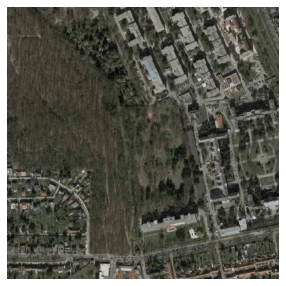

In [5]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [6]:
get_y_fn = lambda x: path_lbl+f'/mask_highway_{x.stem}.tif'

In [8]:
img_f

PosixPath('/projects/qg35/jlgao2/FYP-Sandbox/data/h5/new/9146800_5820000.png')

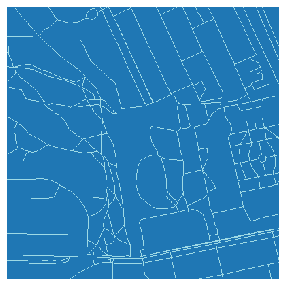

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([400, 400]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [14]:
mask.size

torch.Size([400, 400])

In [15]:
codes = array(['Background' , 'Building'])

In [16]:
codes

array(['Background', 'Building'], dtype='<U10')

In [17]:
mask.data.sum()

tensor(8381)

## Datasets

In [18]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7586MB of GPU RAM free


In [19]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [20]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

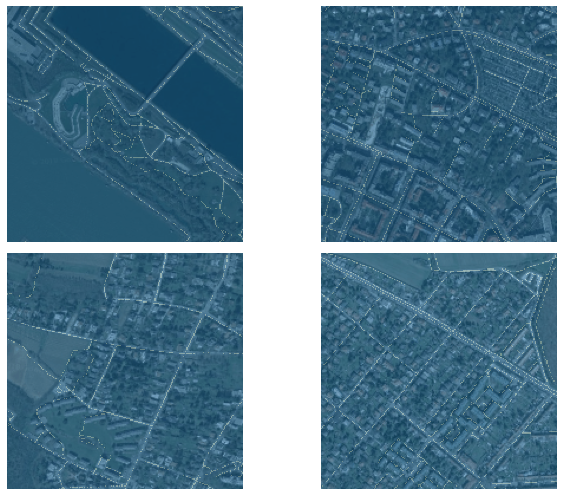

In [21]:
data.show_batch(2, figsize=(10,7))

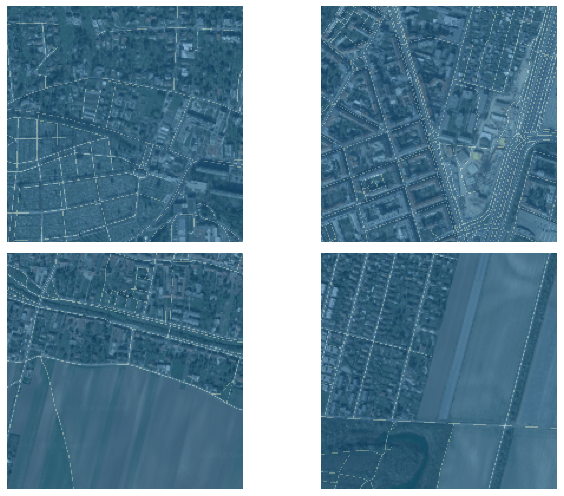

In [22]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [23]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [24]:
metrics=acc_camvid

In [25]:
wd=1e-2

In [26]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


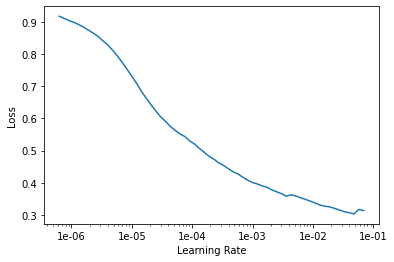

In [27]:
lr_find(learn)
learn.recorder.plot()

In [52]:
lr=1e-2

In [29]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.126496,0.132627,0.000004,00:29
1,0.120984,0.124642,0.000046,00:28
2,0.117013,0.122362,0.000460,00:28
3,0.118351,0.121918,0.000919,00:28
4,0.118127,0.120414,0.000017,00:28
5,0.116487,0.118609,0.002319,00:28
6,0.129708,0.122018,0.003020,00:28
7,0.116071,0.120022,0.006831,00:28
8,0.113735,0.117305,0.005965,00:28
9,0.110240,0.115477,0.003205,00:28


In [30]:
learn.save('stage-1')

In [31]:
learn.load('stage-1');

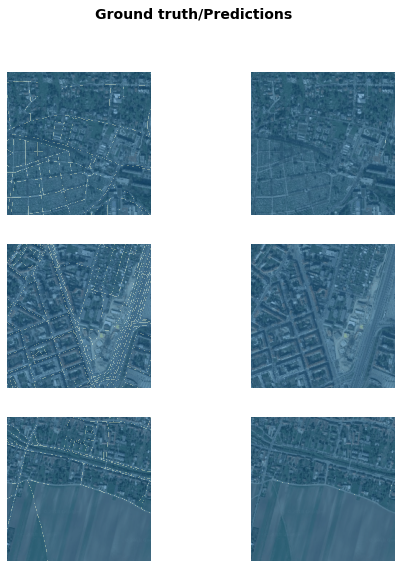

In [32]:
learn.show_results(rows=3, figsize=(8,9))

In [33]:
learn.unfreeze()

In [34]:
lrs = slice(lr/400,lr/4)

In [35]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.110596,0.115069,0.005411,00:33
1,0.108654,0.115017,0.005601,00:32
2,0.109843,0.114679,0.006150,00:32
3,0.110807,0.114261,0.003246,00:33
4,0.107258,0.113940,0.008056,00:33
5,0.109219,0.114907,0.004873,00:33
6,0.109590,0.113695,0.006638,00:33
7,0.108425,0.113588,0.018088,00:32
8,0.108674,0.112651,0.011028,00:33
9,0.109615,0.112830,0.005042,00:33


In [36]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [37]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 7065MB of GPU RAM free


In [38]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [39]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [40]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


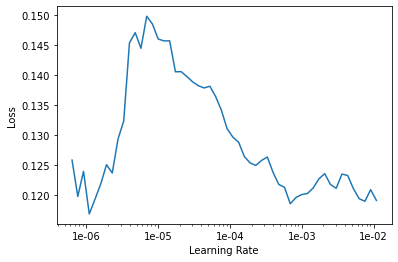

In [41]:
lr_find(learn)
learn.recorder.plot()

In [42]:
lr=1e-3

In [43]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.114376,0.111995,0.013918,01:47
1,0.108695,0.110642,0.009757,01:47
2,0.111625,0.109649,0.007604,01:47
3,0.104486,0.109908,0.021251,01:47
4,0.107047,0.112510,0.021284,01:47
5,0.103132,0.108356,0.009783,01:47
6,0.101509,0.108091,0.027742,01:47
7,0.104411,0.110120,0.023713,01:47
8,0.101398,0.109239,0.012338,01:47
9,0.103628,0.106486,0.025463,01:47


In [44]:
learn.save('stage-1-big')

In [45]:
learn.load('stage-1-big');

In [46]:
learn.unfreeze()

In [47]:
lrs = slice(1e-6,lr/10)

In [48]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.096036,0.106447,0.032084,02:03
1,0.097375,0.106122,0.026458,02:03
2,0.100029,0.106186,0.024959,02:04
3,0.101517,0.105746,0.033520,02:03
4,0.089055,0.107086,0.028441,02:04
5,0.097356,0.105905,0.028517,02:04
6,0.090276,0.106611,0.030385,02:04
7,0.095672,0.105514,0.029718,02:04
8,0.103538,0.106109,0.030965,02:04
9,0.099791,0.105769,0.028502,02:04


In [49]:
learn.save('stage-2-big')

In [50]:
learn.load('stage-2-big');

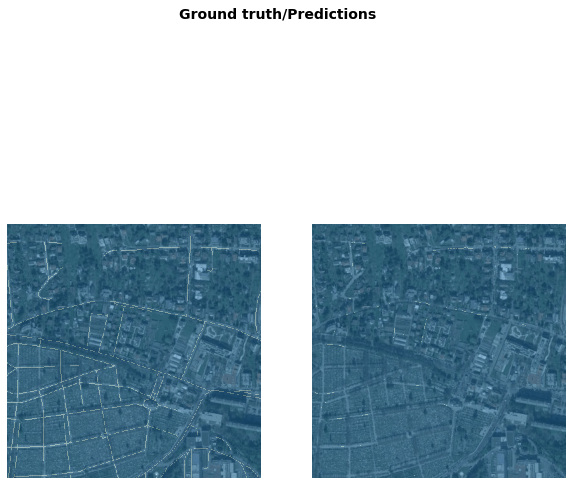

In [51]:
learn.show_results(rows=3, figsize=(10,10))

## fin